In [88]:
import numpy as np
import pandas as pd
import biogeme
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Benchmark

%run -i "binary_specific_netherlands.py"

           Value  Std err  t-test  p-value  Rob. Std err  Rob. t-test  \
ASC_CAR   -0.798     0.27   -2.95  0.00315         0.275         -2.9   
BETA_COST -0.113   0.0232   -4.85 1.21e-06        0.0241        -4.67   
BETA_TT    -1.33    0.344   -3.86 0.000115         0.354        -3.75   

           Rob. p-value  
ASC_CAR         0.00379  
BETA_COST      3.03e-06  
BETA_TT         0.00018  
Nbr of observations: 228
LL(0) =    -158.038
LL(beta) = -123.133
rho bar square = 0.202
Output file: binary_specific_netherlands.html


In [89]:
ned_data_rp = pd.read_table("Data/netherlandsRP.dat")

X = ned_data_rp[['car_cost', 'rail_cost', 'car_ivtt', 'car_walk_time', 'rail_ivtt', 'rail_acc_time', 'rail_egr_time']]
X_updt = X.copy()
X_updt['car_tt'] = X['car_ivtt'] +X['car_walk_time']
X_updt['rail_tt'] = X['rail_ivtt'] +X['rail_acc_time'] +X['rail_egr_time']

rate_G2E = 0.44378022
X_updt['car_cost'] = X_updt['car_cost'] * rate_G2E
X_updt['rail_cost'] = X_updt['rail_cost'] * rate_G2E
X_updt = X_updt.drop(columns=['car_ivtt', 'car_walk_time', 'rail_ivtt', 'rail_acc_time', 'rail_egr_time'])

y = ned_data_rp['choice']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(X_updt, y, test_size=0.20, random_state=42)

In [5]:
import xgboost as xgb 

xgb_constrained = xgb.XGBClassifier(#objective='binary:logistic', 
                                    #learning_rate = 0.2,
                                    n_estimators = 100, 
                                    max_depth = 1, 
                                    random_state = 42,
                                    monotone_constraints = (-1, -1, -1, -1),
                                    interaction_constraints = [["car_cost"], ["rail_cost"], ["car_tt"], ["rail_tt"]]
                                   )

In [6]:
#xgb_constrained.get_params()

In [7]:
eval_set = [(X_validate, y_validate)]
xgb_constrained.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-logloss:0.69091
[1]	validation_0-logloss:0.68542
[2]	validation_0-logloss:0.67584
[3]	validation_0-logloss:0.68054
[4]	validation_0-logloss:0.68116
[5]	validation_0-logloss:0.68812
[6]	validation_0-logloss:0.69205
[7]	validation_0-logloss:0.68770
[8]	validation_0-logloss:0.69072
[9]	validation_0-logloss:0.69086
[10]	validation_0-logloss:0.69321
[11]	validation_0-logloss:0.69635
[12]	validation_0-logloss:0.69368
[13]	validation_0-logloss:0.69369
[14]	validation_0-logloss:0.69517
[15]	validation_0-logloss:0.69642
[16]	validation_0-logloss:0.69647
[17]	validation_0-logloss:0.69506
[18]	validation_0-logloss:0.69596
[19]	validation_0-logloss:0.69709
[20]	validation_0-logloss:0.69615
[21]	validation_0-logloss:0.69677
[22]	validation_0-logloss:0.69679
[23]	validation_0-logloss:0.69736
[24]	validation_0-logloss:0.69782
[25]	validation_0-logloss:0.69830
[26]	validation_0-logloss:0.69889
[27]	validation_0-logloss:0.69834
[28]	validation_0-logloss:0.69874
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=[['car_cost'], ['rail_cost'], ['car_tt'],
                                       ['rail_tt']],
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=(-1, -1, -1, -1), n_estimators=100,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=42, ...)

In [8]:
y_pred=xgb_constrained.predict(X_validate)

from sklearn.metrics import accuracy_score

accuracy_score(y_validate, y_pred)

0.5869565217391305

In [11]:
from xgbfir_modified import getHistoData

histoData = getHistoData(xgb_constrained)

In [13]:
histoData_df = pd.DataFrame(np.reshape(getHistoData(xgb_constrained), (-1, 4)), columns= ['Feature', 'Split point', 'Left leaf value', 'Right leaf value'])

In [15]:
histoData_df['Feature'] == 'rail_cost

array(['rail_tt', 'rail_cost', 'car_tt', 'car_cost'], dtype=object)

In [76]:
def arrangeHistoDataForPlot(data):
    
    histoDataForPlot = {}
    for f in data.Feature.unique():
        split_points = []
        histo_value = [0]
        final_histo = []
        
        specHistFeature = data[data.Feature == f]
        orderData = specHistFeature.sort_values(by = ['Split point'], ignore_index = True)
        for i, s in enumerate(orderData['Split point']):
            if s not in split_points:
                split_points.append(s)
                right_side = [histo_value[-1] + float(orderData.loc[i, 'Right leaf value'])]
                left_side = [h + float(orderData.loc[i, 'Left leaf value']) for h in histo_value]
                histo_value = left_side + right_side
            else:
                left_side = [h + float(orderData.loc[i, 'Left leaf value']) for h in histo_value[:-1]]
                right_side = [histo_value[-1] + float(orderData.loc[i, 'Right leaf value'])]
                histo_value = left_side + right_side
                
        histoDataForPlot[f] = {'Splitting points': split_points,
                               'Histogram values': histo_value}
        
    return histoDataForPlot
                
        

In [85]:
len(a['rail_tt']['Splitting points'])

2

In [ ]:
np.linspace(x_min, x_max, num_points)

In [99]:
def buildHistoLine(split_value_histo, x_min, x_max, num_points):
    
    x_values = np.linspace(x_min, x_max, num_points)
    histo_line = []
    i = 0
    max_i = len(split_value_histo['Splitting points'])
    for x in x_values:
        if x < float(split_value_histo['Splitting points'][i]):
            histo_line += [float(split_value_histo['Histogram values'][i])]
        else:
            histo_line += [float(split_value_histo['Histogram values'][i+1])]
            if i < max_i-1:
                i+=1
    
    return x_values, histo_line
        
        

In [102]:
def plotHisto(data, X):
    
    dict_histograms = arrangeHistoDataForPlot(data)
    
    for f in data.Feature.unique():
        
        x, histo_line = buildHistoLine(dict_histograms[f], 0, 1.25*max(X[f]), 100)
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(x, histo_line)

C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nicol\anaconda3\envs\biogeme\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


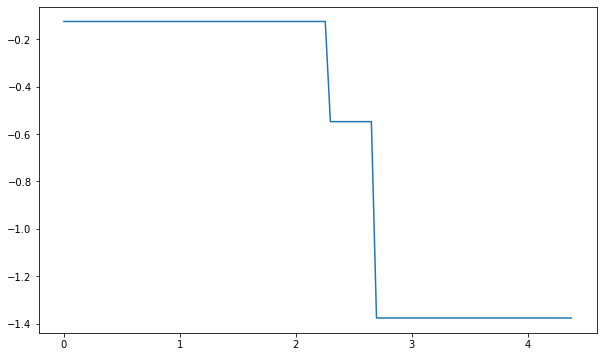

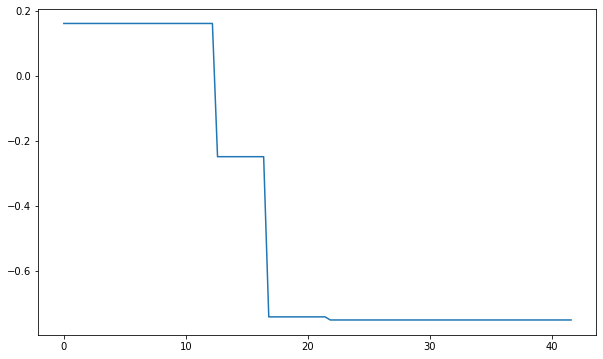

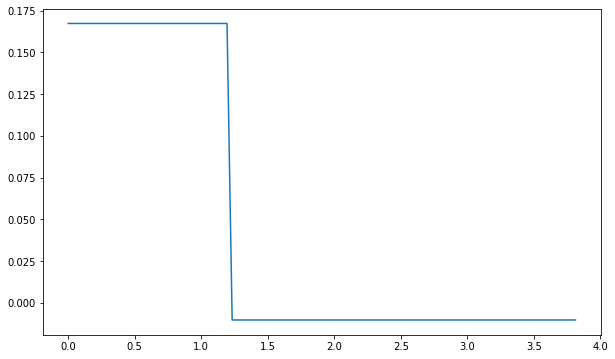

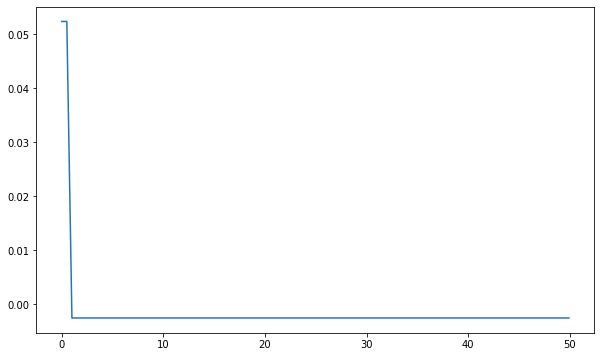

In [103]:
plotHisto(histoData_df, X_updt)

In [12]:
import xgbfir

xgbfir.saveXgbFI(xgb_constrained, OutputXlsxFile='Not_modified.xlsx')

In [12]:
%run -i "getHisto.py"
histoData

[0]	validation_0-logloss:0.69091
[1]	validation_0-logloss:0.68542
[2]	validation_0-logloss:0.67584
[3]	validation_0-logloss:0.68054
[4]	validation_0-logloss:0.68116
0.5652173913043478
